#  TissUUmaps Jupyter integration with Spage2vec

This notebook will show you how to integrate a code from Jupyter notebook with our interactive viewer TissUUmaps. For this example we use the method spage2vec - unsupervised segmentation-free approach for decrypting the spatial transcriptomic heterogeneity of complex tissues at subcellular resolution.
# ![title](spage2vec.png)

The steps to achieve TissUUmaps integration with Spage2vec:
1. Import the necessary libraries
2. Load input data for Spage2vec
3. Spage2vec
4. Clustering
5. Visualize the results in TissUUmaps

## 1. Import the necessary libraries

In [1]:
%%capture --no-display
import networkx as nx
import pandas as pd
import numpy as np
import math
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree
from tensorflow.keras.utils import to_categorical

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.layer.graphsage import AttentionalAggregator
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from stellargraph import globalvar
import scipy.cluster

import warnings
warnings.filterwarnings("ignore")

## 2. Load input data for Spage2vec

In [2]:
# Load gene panel taglist
tagList_df =pd.DataFrame(['3110035E14Rik','6330403K07Rik','Adgrl2','Aldoc','Arpp21','Atp1b1','Bcl11b','Cadps2','Calb1','Calb2','Calm2','Cck','Cdh13','Chodl','Chrm2','Cnr1','Col25a1','Cort','Cox6a2','Cplx2','Cpne5','Crh','Crhbp','Cryab','Crym','Cux2','Cxcl14','Enc1','Enpp2','Fam19a1','Fos','Fxyd6','Gabrd','Gad1','Gap43','Gda','Grin3a','Hapln1','Htr3a','Id2','Kcnk2','Kctd12','Kit','Lamp5','Lhx6','Ndnf','Neurod6','Nos1','Nov','Npy','Npy2r','Nr4a2','Nrn1','Nrsn1','Ntng1','Pax6','Pcp4','Pde1a','Penk','Plcxd2','Plp1','Pnoc','Prkca','Pthlh','Pvalb','Pvrl3','Qrfpr','Rab3c','Rasgrf2','Rbp4','Reln','Rgs10','Rgs12','Rgs4','Rorb','Rprm','Satb1','Scg2','Sema3c','Serpini1','Slc17a8','Slc24a2','Slc6a1','Snca','Sncg','Sst','Sulf2','Synpr','Tac1','Tac2','Th','Thsd7a','Tmsb10','Trp53i11','Vip','Vsnl1','Wfs1','Yjefn3','Zcchc12'], columns=['Gene'])
# Load spot data for 4_1 right ISS dataset
file_name = 'pciSeq_CA1Dapi'
barcodes_df = pd.read_csv('./data/pciSeq_CA1Dapi/'+ file_name + "_spots.csv", sep = ",", names=['global_X_pos','global_Y_pos','Gene'],header=0)  
barcodes_df.head() 

,global_X_pos,global_Y_pos,Gene
0,133,4223,Pvalb
1,141,4166,Cplx2
2,143,4258,3110035E14Rik
3,145,4267,Lamp5
4,146,4261,Nov


(-298.8003116940346, 6318.8003116940345, 6204.400319950829, -272.4003199508302)

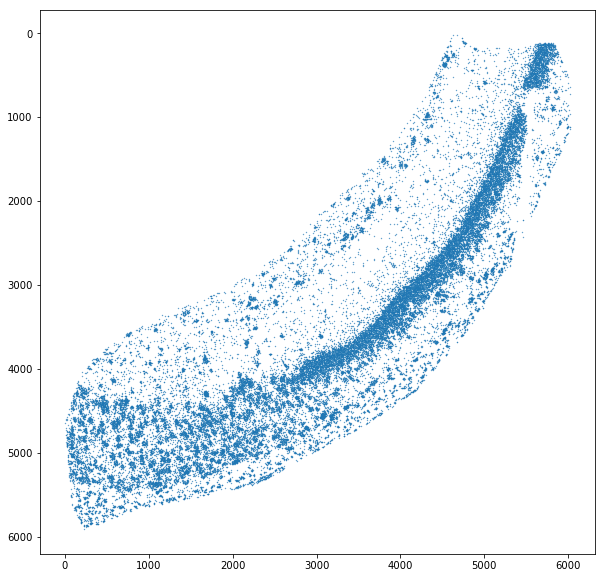

In [3]:
import matplotlib.pyplot as plt
X = barcodes_df.global_X_pos
Y = barcodes_df.global_Y_pos

plt.figure(figsize=(10,10))
plt.scatter(X,Y,s=0.1)
plt.gca().invert_yaxis()
plt.axis('scaled')

## 3. Spage2vec

25.612496949731394


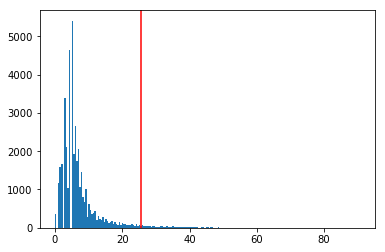

In [4]:
# Auxiliary function to compute d_max
def plotNeighbor(barcodes_df):
    barcodes_df.reset_index(drop=True, inplace=True)
    
    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    d,i = kdT.query(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T,k=2)
    plt.hist(d[:,1],bins=200)
    plt.axvline(x=np.percentile(d[:,1],97),c='r')
    print(np.percentile(d[:,1],97))
    d_th = np.percentile(d[:,1],97)
    return d_th

# Compute d_max for generating spatial graph
d_th = plotNeighbor(barcodes_df)

In [5]:
# Auxiliary function to build spatial gene expression graph
def buildGraph(barcodes_df, d_th, tagList_df, w, conf):
    G = nx.Graph()
    features =[] 
    barcodes_df.reset_index(drop=True, inplace=True)
    
    gene_list = tagList_df.Gene.values
    # Generate node categorical features
    one_hot_encoding = dict(zip(gene_list,to_categorical(np.arange(gene_list.shape[0]),num_classes=gene_list.shape[0]).tolist()))
    if conf:
        one_hot_encoding['GeneX'][0] = 0.1
        one_hot_encoding['GeneY'][1] = 0.1
    barcodes_df["feature"] = barcodes_df['Gene'].map(one_hot_encoding).tolist()
    barcodes_df.head()
    features.append(np.vstack(barcodes_df.feature.values))

    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    res = kdT.query_pairs(d_th)
    
    if w:
        weights = []
        for tup in res:
            if (tup[0]>42448) | (tup[1]>42448):
                weights.append(0.1)
            else:
                weights.append(1)  
        res = [(x[0],x[1], w) for x, w in zip(list(res), weights)]
    else:
        res = [(x[0],x[1]) for x in list(res)]

    # Add nodes to graph
    G.add_nodes_from((barcodes_df.index.values), test=False, val=False, label=0)
    # Add node features to graph
    nx.set_node_attributes(G,dict(zip((barcodes_df.index.values), barcodes_df.feature)), 'feature')
    # Add edges to graph
    if w:
        G.add_weighted_edges_from(res)
        print('weighted')
    else:
        G.add_edges_from(res)

    return G, barcodes_df

In [6]:
# Build spatial gene expression graph
weights = False
confidence = False
G, barcodes_df = buildGraph(barcodes_df, d_th, tagList_df,weights, confidence)
barcodes_df.shape

(42448, 4)

In [7]:
# Remove components with less than N nodes
N=3
node_removed = []
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
            node_removed.append(node)
            G.remove_node(node)
            
barcodes_df = barcodes_df[~barcodes_df.index.isin(node_removed)]
barcodes_df.reset_index(drop=True, inplace=True)
barcodes_df.shape

100%|██████████| 2350/2350 [00:00<00:00, 292872.22it/s]


(40483, 4)

#### 1. Create the Stellargraph with node features.

In [8]:
G = sg.StellarGraph(G, node_features="feature")

#### 2. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [9]:
nodes = list(G.nodes())
number_of_walks = 1
length = 2

#### 3. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [10]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks, seed=42)

#### 4. Create a node pair generator:

In [11]:
batch_size = 50
epochs = 50
num_samples = [20, 10]

In [12]:
if weights:
    generator = GraphSAGELinkGenerator(G, batch_size, num_samples, seed=42, weighted=True)
    print('weighted')
else:
    generator = GraphSAGELinkGenerator(G, batch_size, num_samples, seed=42)

train_gen = generator.flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 3239 batches generated on the fly per epoch.


#### 5. Create neural network model

In [13]:
%%capture --no-display
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.0, normalize="l2", kernel_regularizer='l1')

In [14]:
%%capture --no-display
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.build()

In [15]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [16]:
import os, datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("pciSeq-%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

#### 6. Train neural network model

In [17]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=8,
    shuffle=True,
    callbacks=[earlystop_callback]
)

Epoch 1/50
3239/3239 [==============================] - 383s 118ms/step - loss: 4.3983 - binary_accuracy: 0.7509
Epoch 2/50
3239/3239 [==============================] - 418s 129ms/step - loss: 0.8099 - binary_accuracy: 0.7552
Epoch 3/50
3239/3239 [==============================] - 420s 130ms/step - loss: 0.5994 - binary_accuracy: 0.7572
Epoch 4/50
3239/3239 [==============================] - 420s 130ms/step - loss: 0.5786 - binary_accuracy: 0.7584
Epoch 5/50
3239/3239 [==============================] - 1730s 534ms/step - loss: 0.5709 - binary_accuracy: 0.7578
Epoch 6/50
3239/3239 [==============================] - 364s 112ms/step - loss: 0.5662 - binary_accuracy: 0.7588
Epoch 7/50
3239/3239 [==============================] - 387s 120ms/step - loss: 0.5626 - binary_accuracy: 0.7616
Epoch 8/50
3239/3239 [==============================] - 384s 119ms/step - loss: 0.5608 - binary_accuracy: 0.7622
Epoch 9/50
3239/3239 [==============================] - 386s 119ms/step - loss: 0.5588 - binary

#### Extract node embeddings

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [20]:
embedding_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

In [21]:
nodes = list(G.nodes())
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=42).flow(nodes)

In [22]:
node_embeddings = embedding_model.predict_generator(node_gen, workers=12, verbose=1)
np.save('./data/pciSeq_CA1Dapi/'+ 'embedding_'+file_name+'.npy',node_embeddings)

810/810 [==============================] - 24s 30ms/step


## 4. Clustering

In [23]:
node_embeddings = np.load('./data/pciSeq_CA1Dapi/'+ 'embedding_'+file_name+'.npy')

In [24]:
#clustering
def clustering(embedding, barcodes):
    adata = sc.AnnData(X=embedding)
    sc.pp.neighbors(adata, n_neighbors=15)
    sc.tl.leiden(adata, random_state = 42)
    adata.obs['Gene'] = barcodes.Gene.values
    barcodes['cluster'] = adata.obs['leiden'].values

    return barcodes

In [25]:
import scanpy as sc
barcodes_df = barcodes_df.drop(columns=['feature'])
barcodes_df = clustering(node_embeddings, barcodes_df)

In [26]:
# Auxiliary functions for merging clusters
def post_merge(df, labels, post_merge_cutoff, linkage_method='single', 
               linkage_metric='correlation', fcluster_criterion='distance', name='', save=False):
    """
    Merge clusters based on likage and a cutoff. The mean expression levels of 
    the clusters are linked and them merged based on the cutoff provided.
    Input:
    `df`(Pandas dataframe): df with expression matrix. row-genes, col-cells.
    `labels`(list/array): Labels of the cells.
    `post_merge_cutoff`(float): Merge clusters that have a distance from each 
        other below the cutoff.
    `linkage_method`(string): Scipy linkage methods. Default = 'single'
    `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
    `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'

    Returns:
    `new_labels`(list): List of new cell labels after merging. 
    Additionally it plots the dendrogram showing which clusters are merged.

    """
    Z = scipy.cluster.hierarchy.linkage(df.T, method=linkage_method, metric=linkage_metric)
    merged_labels_short = scipy.cluster.hierarchy.fcluster(Z, post_merge_cutoff, criterion=fcluster_criterion)

    #Update labels  
    label_conversion = dict(zip(df.columns, merged_labels_short))
    label_conversion_r = dict(zip(merged_labels_short, df.columns))
    new_labels = [label_conversion[i] for i in labels] 

    #Plot the dendrogram to visualize the merging
    fig, ax = plt.subplots(figsize=(20,10))
    scipy.cluster.hierarchy.dendrogram(Z, labels=df.columns ,color_threshold=post_merge_cutoff)
    ax.hlines(post_merge_cutoff, 0, ax.get_xlim()[1])
    ax.set_title('Merged clusters')
    ax.set_ylabel(linkage_metric, fontsize=20)
    ax.set_xlabel('pre-merge cluster labels', fontsize=20)
    ax.tick_params(labelsize=10)
    
#     if save == True:
#         fig.savefig('../figures/{}.svg'.format(name), dpi=500)

    return new_labels

def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to 
    get the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a

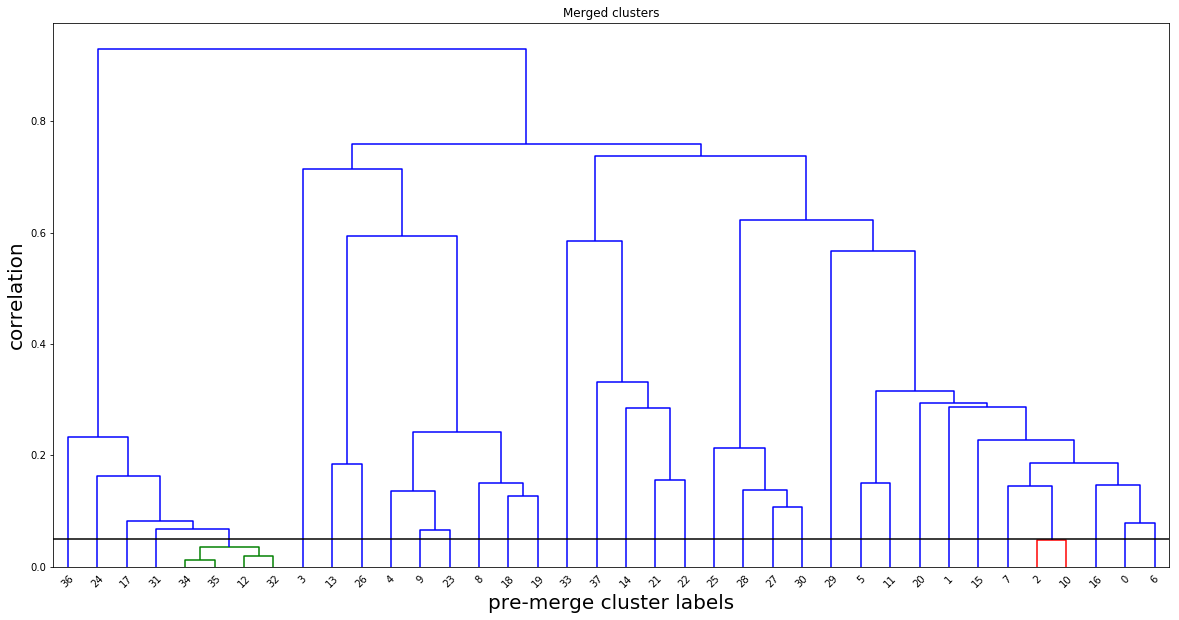

In [27]:
# postmerge 
hm = barcodes_df.groupby(['Gene','cluster']).size().unstack(fill_value=0)
hm = hm.append(pd.DataFrame(np.zeros((tagList_df[~tagList_df.Gene.isin(hm.index.values)].values.reshape(-1).shape[0],hm.shape[1])), index=tagList_df[~tagList_df.Gene.isin(hm.index.values)].values.reshape(-1), columns=hm.columns)).sort_index()
scaler = StandardScaler()
hm = pd.DataFrame(scaler.fit_transform(hm.values), columns=hm.columns, index=hm.index)
hm_merge = post_merge(hm, hm.columns, 0.05, linkage_metric='correlation', linkage_method='average', name='SupFig3Dend', save=True)
hm = barcodes_df.groupby(['Gene','cluster']).size().unstack(fill_value=0)
hm = hm.append(pd.DataFrame(np.zeros((tagList_df[~tagList_df.Gene.isin(hm.index.values)].values.reshape(-1).shape[0],hm.shape[1])), index=tagList_df[~tagList_df.Gene.isin(hm.index.values)].values.reshape(-1), columns=hm.columns)).sort_index()
hm_macro = pd.DataFrame(np.zeros((hm.shape[0], np.unique(hm_merge).shape[0])), index=hm.index, columns=np.unique(hm_merge))
for d in np.unique(hm_merge):
    hm_macro.loc[:,d] = hm.iloc[:,np.where(np.array(hm_merge)==d)[0]].sum(axis=1)
hm_macro = pd.DataFrame(scaler.fit_transform(hm_macro.values), columns=hm_macro.columns, index=hm_macro.index)
hm_merge = np.array(hm_merge)
for macro_go in np.unique(hm_merge):
    barcodes_df.loc[barcodes_df.cluster.astype(int).isin(np.where(np.isin(hm_merge,[macro_go]))[0]),'macro_cluster'] = macro_go
barcodes_df['cluster'] = barcodes_df['macro_cluster']
del barcodes_df['macro_cluster']

In [28]:
barcodes_df.to_csv('./data/pciSeq_CA1Dapi/'+ file_name + '_clustered.csv')
barcodes_df.head()

,global_X_pos,global_Y_pos,Gene,cluster
0,133,4223,Pvalb,12.0
1,141,4166,Cplx2,22.0
2,143,4258,3110035E14Rik,10.0
3,145,4267,Lamp5,8.0
4,146,4261,Nov,8.0


## 5. Visualize the results in TissUUmaps

In [29]:
import tissuumaps.jupyter as tj

In [30]:
imageFiles = ['./data/pciSeq_CA1Dapi/'+ file_name + '.tif']
csvFiles = ['./data/pciSeq_CA1Dapi/'+ file_name + '_clustered.csv']

In [31]:
tj.loaddata(imageFiles, csvFiles, xSelector="global_X_pos", ySelector="global_Y_pos",
        keySelector="cluster", height=600, tmapFilename="mainProject")

Creating project file c:\Users\andre\Documents\GitHub\FlaskTissUUmaps\examples\data\pciSeq_CA1Dapi\mainProject.tmap
